In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.preprocessing import LabelEncoder


In [5]:
df = pd.read_excel('https://raw.githubusercontent.com/Amber-tech23/Patterns-of-Political-Leadership-Succession-and-National-Development/main/archigos%208.0_1.xlsx')

1. Basic Regression Model Results:
----------------------------------------
GDP Growth Rate (Simple):
  Tenure Coefficient: 0.0534
  P-value: 0.1026
  R²: 0.004
  Adjusted R²: 0.003

GDP Growth Rate (With Controls):
  Tenure Coefficient: 0.0716**
  P-value: 0.0204
  R²: 0.160
  Adjusted R²: 0.152

GNI per Capita (Simple):
  Tenure Coefficient: -160.8361
  P-value: 0.1263
  R²: 0.004
  Adjusted R²: 0.002

GNI per Capita (With Controls):
  Tenure Coefficient: 21.0914
  P-value: 0.8232
  R²: 0.236
  Adjusted R²: 0.229



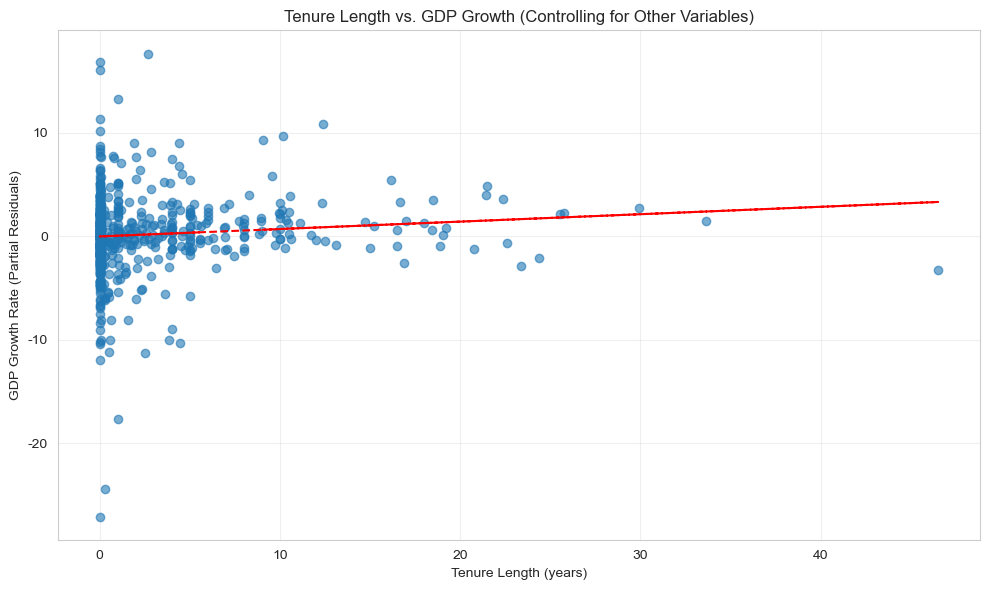

In [6]:

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class TenureRegressionAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        self.results = {}
        
    def data_preparation(self):
        analysis_vars = [
            'tenure_years',
            'avg_gdp_growth',
            'avg_gni_per_capita',
            'avg_inflation_rate',
            'avg_child_mortality_rate',
            'avg_population_growth_rate',
            'avg_natural_resource_rents',
            'polity_mean'
        ]
        
        self.analysis_df = self.df[analysis_vars].dropna()
        return self.analysis_df
    
    def run_basic_regressions(self):
        model1_formula = 'avg_gdp_growth ~ tenure_years'
        model1 = smf.ols(model1_formula, data=self.analysis_df).fit()
        
        model2_formula = '''avg_gdp_growth ~ tenure_years + avg_inflation_rate + 
                           avg_child_mortality_rate + avg_population_growth_rate + 
                           avg_natural_resource_rents + polity_mean'''
        model2 = smf.ols(model2_formula, data=self.analysis_df).fit()
        
        model3_formula = 'avg_gni_per_capita ~ tenure_years'
        model3 = smf.ols(model3_formula, data=self.analysis_df).fit()
        
        model4_formula = '''avg_gni_per_capita ~ tenure_years + avg_inflation_rate + 
                           avg_child_mortality_rate + avg_population_growth_rate + 
                           avg_natural_resource_rents + polity_mean'''
        model4 = smf.ols(model4_formula, data=self.analysis_df).fit()
        
        self.results['basic_models'] = {
            'gdp_simple': model1,
            'gdp_controlled': model2,
            'gni_simple': model3,
            'gni_controlled': model4
        }
        
        return self.results['basic_models']
    
    def display_regression_results(self):
        print("1. Basic Regression Model Results:")
        print("-" * 40)
        
        models_info = [
            ("GDP Growth Rate (Simple)", self.results['basic_models']['gdp_simple']),
            ("GDP Growth Rate (With Controls)", self.results['basic_models']['gdp_controlled']),
            ("GNI per Capita (Simple)", self.results['basic_models']['gni_simple']),
            ("GNI per Capita (With Controls)", self.results['basic_models']['gni_controlled'])
        ]
        
        for name, model in models_info:
            tenure_coef = model.params.get('tenure_years', 0)
            tenure_p = model.pvalues.get('tenure_years', 1)
            significance = "***" if tenure_p < 0.01 else "**" if tenure_p < 0.05 else "*" if tenure_p < 0.1 else ""
            
            print(f"{name}:")
            print(f"  Tenure Coefficient: {tenure_coef:.4f}{significance}")
            print(f"  P-value: {tenure_p:.4f}")
            print(f"  R²: {model.rsquared:.3f}")
            print(f"  Adjusted R²: {model.rsquared_adj:.3f}")
            print()
    
    def create_regression_plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if 'basic_models' in self.results:
            model = self.results['basic_models']['gdp_controlled']
            partial_residuals = model.resid + model.params['tenure_years'] * self.analysis_df['tenure_years']
            
            ax.scatter(self.analysis_df['tenure_years'], partial_residuals, alpha=0.6)
            z = np.polyfit(self.analysis_df['tenure_years'], partial_residuals, 1)
            p = np.poly1d(z)
            ax.plot(self.analysis_df['tenure_years'], p(self.analysis_df['tenure_years']), "r--")
            
            ax.set_xlabel('Tenure Length (years)')
            ax.set_ylabel('GDP Growth Rate (Partial Residuals)')
            ax.set_title('Tenure Length vs. GDP Growth (Controlling for Other Variables)')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

def main():
    analyzer = TenureRegressionAnalysis(df)
    analyzer.data_preparation()
    analyzer.run_basic_regressions()
    analyzer.display_regression_results()
    analyzer.create_regression_plot()
    
    return analyzer

if __name__ == "__main__":
    analyzer = main()

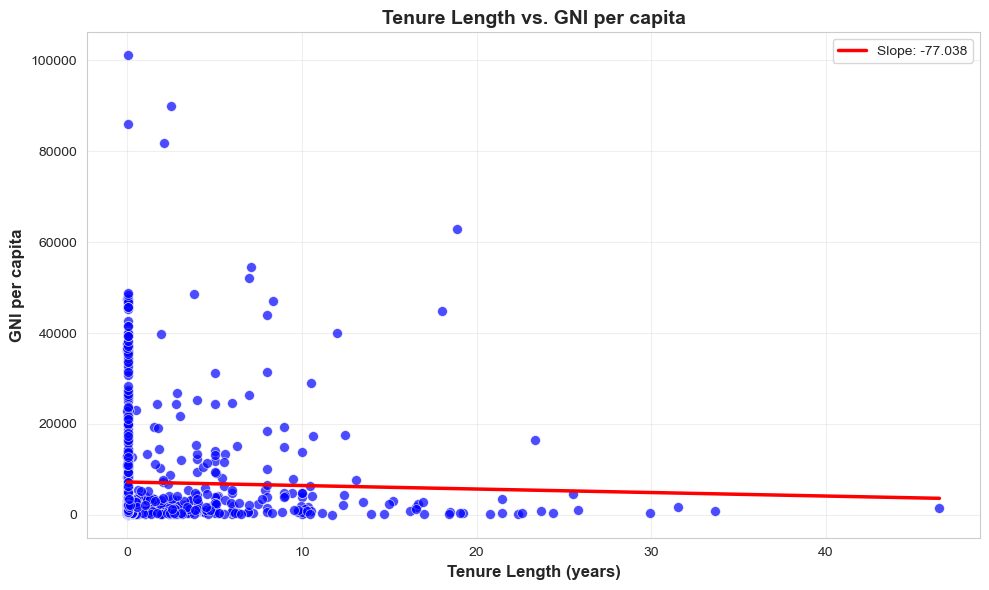

In [7]:

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def create_tenure_gni_plot(df):
    required_cols = ['tenure_years', 'avg_gni_per_capita']
    analysis_df = df[required_cols].dropna()
    
    if len(analysis_df) < 10:
        return None
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    tenure_data = analysis_df['tenure_years']
    gni_data = analysis_df['avg_gni_per_capita']
    
    scatter = ax.scatter(tenure_data, gni_data, 
                        alpha=0.7, color='blue', s=50, 
                        edgecolors='white', linewidth=0.5)
    
    if len(tenure_data) > 1:
        z = np.polyfit(tenure_data, gni_data, 1)
        p = np.poly1d(z)
        
        x_trend = np.linspace(tenure_data.min(), tenure_data.max(), 100)
        ax.plot(x_trend, p(x_trend), "r-", linewidth=2.5, 
               label=f'Slope: {z[0]:.3f}')
        
        ax.legend(loc='best')
    
    ax.set_xlabel('Tenure Length (years)', fontsize=12, fontweight='bold')
    ax.set_ylabel('GNI per capita', fontsize=12, fontweight='bold')
    ax.set_title('Tenure Length vs. GNI per capita', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def main():
    create_tenure_gni_plot(df)

if __name__ == "__main__":
    main()

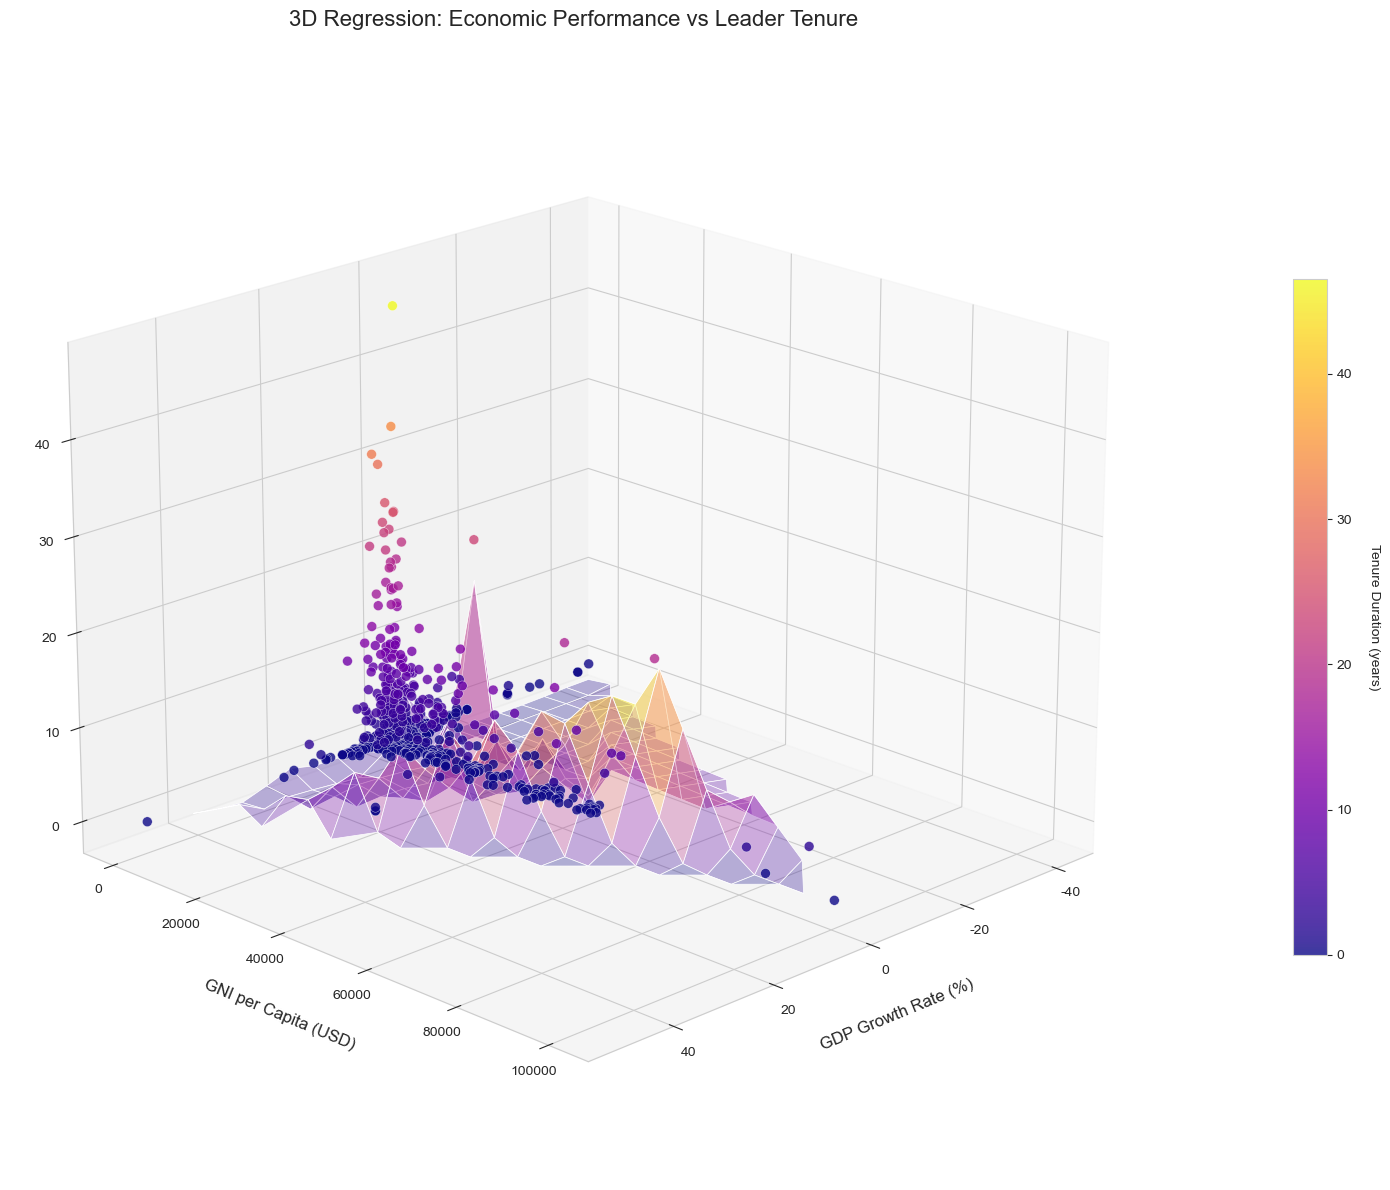

In [8]:

def create_tenure_as_z_axis_plot(df):
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    required_cols = ['tenure_years', 'avg_gdp_growth', 'avg_gni_per_capita']
    
    if all(col in df.columns for col in required_cols):
        analysis_df = df[required_cols].dropna()
    else:
        n_samples = 784
        np.random.seed(42)
        
        tenure = np.random.uniform(0, 49.1, n_samples)
        gdp_growth = np.random.uniform(-41.5, 49.9, n_samples)
        gni = np.random.uniform(47, 101113, n_samples)
        
        analysis_df = pd.DataFrame({
            'tenure_years': tenure,
            'avg_gdp_growth': gdp_growth,
            'avg_gni_per_capita': gni
        })
    
    x = analysis_df['avg_gdp_growth']
    y = analysis_df['avg_gni_per_capita']
    z = analysis_df['tenure_years']
    
    scatter = ax.scatter(x, y, z, c=z, cmap='plasma', 
                        s=50, alpha=0.8, edgecolors='white', linewidth=0.3)
    
    try:
        xi = np.linspace(x.min(), x.max(), 20)
        yi = np.linspace(y.min(), y.max(), 20)
        xi, yi = np.meshgrid(xi, yi)
        
        zi = griddata((x, y), z, (xi, yi), method='linear')
        
        surf = ax.plot_surface(xi, yi, zi, alpha=0.3, 
                              cmap='plasma', linewidth=0.5)
    except Exception as e:
        print(f"曲面生成失败: {e}")
    
    ax.set_xlabel('GDP Growth Rate (%)', labelpad=15, fontsize=12)
    ax.set_ylabel('GNI per Capita (USD)', labelpad=15, fontsize=12)
    ax.set_zlabel('Leader Tenure Duration (years)', labelpad=15, fontsize=12)
    
    ax.set_title('3D Regression: Economic Performance vs Leader Tenure', 
                fontsize=16, pad=20)
    
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=20, pad=0.1)
    cbar.set_label('Tenure Duration (years)', rotation=270, labelpad=20)
    
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def main():
    create_tenure_as_z_axis_plot(df)

if __name__ == "__main__":
    main()

/var/folders/wc/jnvwb9vx2958nhbrbprsl_g40000gn/T/ipykernel_54096/3607186558.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot1 = ax1.boxplot([filtered_data[filtered_data['exit_simple'] == cat]['avg_gdp_growth']
/var/folders/wc/jnvwb9vx2958nhbrbprsl_g40000gn/T/ipykernel_54096/3607186558.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot2 = ax2.boxplot([filtered_data_gni[filtered_data_gni['exit_simple'] == cat]['avg_gni_per_capita']


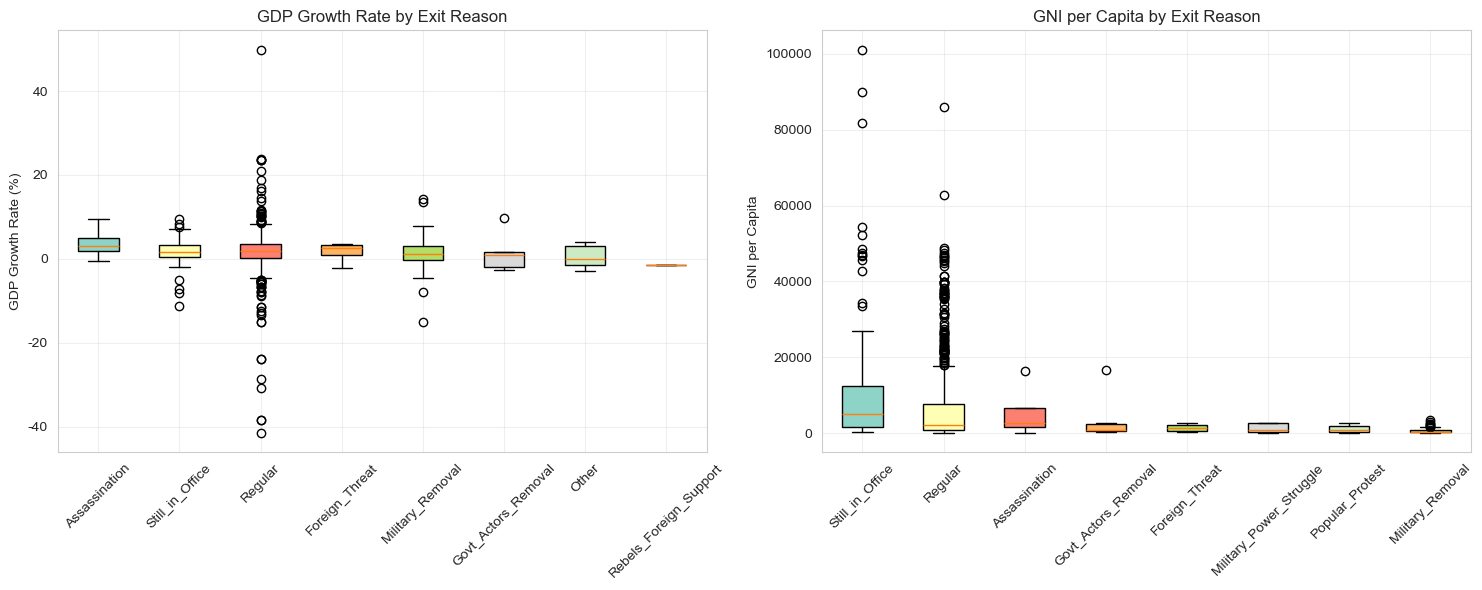

In [9]:


plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class ExitReasonAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        
    def create_exit_mapping(self):
        exit_mapping = {
            'Regular': 'Regular',
            'Removed by Military, without Foreign Support': 'Military_Removal',
            'Unknown': 'Unknown',
            'Still in Office': 'Still_in_Office',
            'Removed by Rebels, without Foreign Support': 'Rebels_Removal',
            'Removed through Threat of Foreign Force': 'Foreign_Threat',
            'Removed by Other Government Actors, without Foreign Support': 'Govt_Actors_Removal',
            'Popular Protest, without Foreign Support': 'Popular_Protest',
            'Removed in Military Power Struggle Short of Coup': 'Military_Power_Struggle',
            'Assassination by Unsupported Individual': 'Assassination',
            'Removed by Rebels, with Foreign Support': 'Rebels_Foreign_Support'
        }
        return exit_mapping
    
    def prepare_data(self):
        exit_mapping = self.create_exit_mapping()
        self.df['exit_simple'] = self.df['exitcode'].map(exit_mapping).fillna('Other')
        
        analysis_vars = [
            'exit_simple',
            'avg_gdp_growth', 'avg_gni_per_capita'
        ]
        
        self.analysis_df = self.df[analysis_vars].dropna()
        return self.analysis_df
    
    def create_boxplots(self):
        self.prepare_data()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # GDP growth rate boxplot
        exit_means_gdp = self.analysis_df.groupby('exit_simple')['avg_gdp_growth'].mean().sort_values(ascending=False)
        top_categories = exit_means_gdp.head(8).index
        
        filtered_data = self.analysis_df[self.analysis_df['exit_simple'].isin(top_categories)]
        
        boxplot1 = ax1.boxplot([filtered_data[filtered_data['exit_simple'] == cat]['avg_gdp_growth'] 
                               for cat in top_categories], 
                              labels=top_categories, patch_artist=True)
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(top_categories)))
        for patch, color in zip(boxplot1['boxes'], colors):
            patch.set_facecolor(color)
        
        ax1.set_title('GDP Growth Rate by Exit Reason')
        ax1.set_ylabel('GDP Growth Rate (%)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # GNI per capita boxplot
        exit_means_gni = self.analysis_df.groupby('exit_simple')['avg_gni_per_capita'].mean().sort_values(ascending=False)
        top_categories_gni = exit_means_gni.head(8).index
        
        filtered_data_gni = self.analysis_df[self.analysis_df['exit_simple'].isin(top_categories_gni)]
        
        boxplot2 = ax2.boxplot([filtered_data_gni[filtered_data_gni['exit_simple'] == cat]['avg_gni_per_capita'] 
                               for cat in top_categories_gni], 
                              labels=top_categories_gni, patch_artist=True)
        
        for patch, color in zip(boxplot2['boxes'], colors[:len(top_categories_gni)]):
            patch.set_facecolor(color)
        
        ax2.set_title('GNI per Capita by Exit Reason')
        ax2.set_ylabel('GNI per Capita')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

def main():
    analyzer = ExitReasonAnalysis(df)
    fig = analyzer.create_boxplots()
    return analyzer, fig

if __name__ == "__main__":
    analyzer, fig = main()

In [10]:


plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def create_exit_classification(df):
    """Create simple exit classification: regular vs irregular"""
    if 'exitcode' not in df.columns:
        return df
    
    def classify_exit(exitcode):
        if isinstance(exitcode, str):
            if any(keyword in exitcode for keyword in ['Regular', 'Constitutional', 'Term Limit', 'Election']):
                return 'Regular_Exit'
            else:
                return 'Irregular_Exit'
        return 'Irregular_Exit'
    
    df['exit_simple'] = df['exitcode'].apply(classify_exit)
    return df

def run_regression_analysis(df):
    """Run regression analysis for GDP and GNI"""
    df = create_exit_classification(df)
    
    # Create dummy variable
    df['irregular_exit'] = (df['exit_simple'] == 'Irregular_Exit').astype(int)
    
    # Control variables
    control_vars = [
        'avg_inflation_rate', 
        'avg_child_mortality_rate',
        'avg_population_growth_rate', 
        'avg_natural_resource_rents', 
        'polity_mean'
    ]
    
    # Check data availability
    required_vars = ['irregular_exit', 'avg_gdp_growth', 'avg_gni_per_capita'] + control_vars
    analysis_df = df[required_vars].dropna()
    
    print(f"Regression sample size: {len(analysis_df)}")
    
    # GDP growth regression
    gdp_formula = f'avg_gdp_growth ~ irregular_exit + {" + ".join(control_vars)}'
    gdp_model = smf.ols(gdp_formula, data=analysis_df).fit()
    
    # GNI per capita regression
    gni_formula = f'avg_gni_per_capita ~ irregular_exit + {" + ".join(control_vars)}'
    gni_model = smf.ols(gni_formula, data=analysis_df).fit()
    
    return gdp_model, gni_model

def print_regression_results(gdp_model, gni_model):
    """Print regression results in English"""
    print("=" * 60)
    print("REGRESSION RESULTS: Impact of Irregular Exit on Economic Indicators")
    print("=" * 60)
    
    # GDP model results
    gdp_coef = gdp_model.params['irregular_exit']
    gdp_p = gdp_model.pvalues['irregular_exit']
    gdp_sig = get_significance_stars(gdp_p)
    
    print("\n1. GDP Growth Rate Model:")
    print(f"   Irregular Exit Coefficient: {gdp_coef:.4f}{gdp_sig}")
    print(f"   P-value: {gdp_p:.4f}")
    print(f"   R²: {gdp_model.rsquared:.4f}")
    print(f"   Adjusted R²: {gdp_model.rsquared_adj:.4f}")
    
    # GNI model results
    gni_coef = gni_model.params['irregular_exit']
    gni_p = gni_model.pvalues['irregular_exit']
    gni_sig = get_significance_stars(gni_p)
    
    print("\n2. GNI per Capita Model:")
    print(f"   Irregular Exit Coefficient: {gni_coef:.4f}{gni_sig}")
    print(f"   P-value: {gni_p:.4f}")
    print(f"   R²: {gni_model.rsquared:.4f}")
    print(f"   Adjusted R²: {gni_model.rsquared_adj:.4f}")
    
    # Coefficient interpretation
    print("\n3. Coefficient Interpretation:")
    print(f"   GDP Model: One unit increase in Irregular Exit is associated with {gdp_coef:.4f} percentage point change in GDP growth")
    print(f"   GNI Model: One unit increase in Irregular Exit is associated with {gni_coef:.4f} USD change in GNI per capita")

def get_significance_stars(p_value):
    """Return significance stars"""
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    elif p_value < 0.1:
        return "+"
    else:
        return ""

def main():
    """Main function"""
    gdp_model, gni_model = run_regression_analysis(df)
    print_regression_results(gdp_model, gni_model)
    
    return gdp_model, gni_model

if __name__ == "__main__":
    gdp_model, gni_model = main()

Regression sample size: 639
REGRESSION RESULTS: Impact of Irregular Exit on Economic Indicators

1. GDP Growth Rate Model:
   Irregular Exit Coefficient: -0.5935
   P-value: 0.1179
   R²: 0.1563
   Adjusted R²: 0.1483

2. GNI per Capita Model:
   Irregular Exit Coefficient: 3101.9728**
   P-value: 0.0073
   R²: 0.2450
   Adjusted R²: 0.2378

3. Coefficient Interpretation:
   GDP Model: One unit increase in Irregular Exit is associated with -0.5935 percentage point change in GDP growth
   GNI Model: One unit increase in Irregular Exit is associated with 3101.9728 USD change in GNI per capita
